In [1]:
import itertools
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from scipy.stats import uniform
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, pairwise_distances, precision_score, f1_score,\
    recall_score, roc_auc_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform
from sklego.meta import Thresholder
from tqdm import tqdm
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, DiscriminationThreshold, PrecisionRecallCurve, ROCAUC
from yellowbrick.features import ParallelCoordinates, PCA, RadViz
from yellowbrick.model_selection import LearningCurve, RFECV
from yellowbrick.style import set_palette

warnings.simplefilter("ignore", UserWarning)

set_palette("dark")
sns.set(rc={"figure.figsize":(8, 8)})
plt.style.use("cyberpunk")

data_path = Path("../../data").resolve()
os.makedirs(data_path, exist_ok=True)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Preprocessing

In [2]:
tracks_df = pd.read_parquet(data_path / "tracks.pq")

print("tracks_df shape:", tracks_df.shape)
print("...where track_chart_months >= 1:",
      tracks_df[tracks_df["track_chart_months"] >= 1].shape)
print("...where track_chart_months >= 6:",
      tracks_df[tracks_df["track_chart_months"] >= 6].shape)
print("...where artist_country = US:",
      tracks_df[(tracks_df["artist_country"] == "US")].shape)
print("...where artist_country = US and track_chart_months >= 1:",
      tracks_df[(tracks_df["artist_country"] == "US") & (tracks_df["track_chart_months"] >= 1)].shape)
print("...where artist_country = US and track_chart_months >= 6:",
      tracks_df[(tracks_df["artist_country"] == "US") & (tracks_df["track_chart_months"] >= 6)].shape)

print("removing karaoke tracks")
tracks_df = tracks_df[~tracks_df["name"].str.lower().str.contains("karaoke")]
tracks_df = tracks_df[~tracks_df["name"].str.lower().str.contains("originally performed by")]
tracks_df = tracks_df[~tracks_df["name"].str.lower().str.contains("instrumental")]

print("tracks_df shape:", tracks_df.shape)
print("...where track_chart_months >= 1:",
      tracks_df[tracks_df["track_chart_months"] >= 1].shape)
print("...where track_chart_months >= 6:",
      tracks_df[tracks_df["track_chart_months"] >= 6].shape)
print("...where artist_country = US:",
      tracks_df[(tracks_df["artist_country"] == "US")].shape)
print("...where artist_country = US and track_chart_months >= 1:",
      tracks_df[(tracks_df["artist_country"] == "US") & (tracks_df["track_chart_months"] >= 1)].shape)
print("...where artist_country = US and track_chart_months >= 6:",
      tracks_df[(tracks_df["artist_country"] == "US") & (tracks_df["track_chart_months"] >= 6)].shape)

audio_features = [
    "danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness",
    "instrumentalness", "liveness", "valence", "tempo", "time_signature",
]

artist_features = [
    "artist_chart_tracks",
    "artist_nominations",
    "artist_wins",
    "artist_releases",
    "artist_chart_months",
    "artist_chart_months_recently",
    "artist_releases_recently",
    # "major_label",  # this feature is way too noisy and unreliable
]


def chart_status(track):
    if track["track_chart_peak"] == 1:
        return "peaked"
    elif track["track_chart_months"] > 3:
        return "charted_3months"
    elif track["track_chart_months"] >= 1:
        return "charted"
    else:
        return "uncharted"


tracks_df["chart_status"] = tracks_df.apply(chart_status, axis=1)
tracks_df["chart_months"] = tracks_df["track_chart_months"].apply(lambda months: months if months <= 5 else 5)
tracks_df["has_female_artist"] = tracks_df["artist_gender"].apply(lambda gender: int("female" in gender))


def create_test_train_datasets(
        df, x_vars, months=1, test_size=0.40, random_state=42,
        y_label="track_chart_months"):
    df = df[x_vars + [y_label]]
    if "major_label" in df.columns:
        df = df.drop(columns="major_label")
    if "chart_status" in df.columns:
        df = df.drop(columns="chart_status")
    if "chart_months" in df.columns:
        df = df.drop(columns="chart_months")
    df = df.dropna()
    X = df.drop(columns=["track_chart_months"])
    y = (df["track_chart_months"] >= months).astype(int)
    return train_test_split(X, y, stratify=y, test_size=test_size,
                            random_state=random_state)


X_audio_train, X_audio_test, y_audio_train, y_audio_test = create_test_train_datasets(tracks_df, audio_features, months=1)
X_artist_train, X_artist_test, y_artist_train, y_artist_test = create_test_train_datasets(tracks_df, artist_features, months=1)

us_tracks_df = tracks_df[(tracks_df["artist_country"] == "US")]

tracks_df shape: (14967, 69)
...where track_chart_months >= 1: (3259, 69)
...where track_chart_months >= 6: (671, 69)
...where artist_country = US: (5817, 69)
...where artist_country = US and track_chart_months >= 1: (2090, 69)
...where artist_country = US and track_chart_months >= 6: (409, 69)
removing karaoke tracks
tracks_df shape: (14923, 69)
...where track_chart_months >= 1: (3220, 69)
...where track_chart_months >= 6: (662, 69)
...where artist_country = US: (5814, 69)
...where artist_country = US and track_chart_months >= 1: (2089, 69)
...where artist_country = US and track_chart_months >= 6: (409, 69)


In [166]:
tracks_df[audio_features].describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000,14921.000000
mean,0.648819,0.653054,5.309296,-6.580287,0.595805,0.106500,0.241888,0.037445,0.179747,0.505684,121.580153,3.958850
std,0.152102,0.186476,3.615535,3.054328,0.490752,0.104975,0.260063,0.155936,0.142385,0.230427,29.200819,0.297074
min,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.552000,0.537000,2.000000,-7.793000,0.000000,0.038300,0.034000,0.000000,0.094400,0.327000,98.001000,4.000000
50%,0.665000,0.676000,6.000000,-6.031000,1.000000,0.059400,0.141000,0.000000,0.123000,0.506000,120.045000,4.000000
75%,0.759000,0.794000,8.000000,-4.696000,1.000000,0.133000,0.374000,0.000118,0.221000,0.684000,140.003000,4.000000
max,0.983000,0.999000,11.000000,1.509000,1.000000,0.954000,0.996000,0.993000,0.986000,0.982000,230.186000,5.000000


In [167]:
tracks_df[artist_features].describe()

,artist_chart_tracks,artist_nominations,artist_wins,artist_releases,artist_chart_months,artist_chart_months_recently,artist_releases_recently
count,14923.000000,14923.000000,14923.000000,14923.000000,14923.000000,14923.000000,14923.000000
mean,3.308182,0.413523,0.140253,17.318368,7.678818,3.227166,10.399048
std,6.117903,1.436946,0.663414,22.982106,19.783667,8.241838,15.900763
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,5.000000
75%,4.000000,0.000000,0.000000,24.000000,3.000000,1.000000,13.000000
max,31.000000,26.000000,20.000000,334.000000,193.000000,87.000000,282.000000


In [168]:
# tracks released in 2017 by artists who have not previously charted
tracks_new_artists_2017 = tracks_df[
    (tracks_df["year"] == 2017)
    & (tracks_df["artist_chart_months"] == 0)
    & (tracks_df["artist_country"] == "US")
    # & (tracks_df["artist_lifetime_chart_months"] >= 1)
    # & (tracks_df["track_chart_months"] >= 1)
][["artists", "name", "track_chart_months", "artist_chart_months", "artist_lifetime_chart_months"]]
tracks_new_artists_2017

,artists,name,track_chart_months,artist_chart_months,artist_lifetime_chart_months
82,"Dumpstaphunk, Trombone Shorty",Justice,0.0,0.0,0.0
114,Lee Brice,Rumor,2.0,0.0,5.0
144,Two Feet,Love Is a Bitch,0.0,0.0,0.0
212,Portugal. The Man,Feel It Still,9.0,0.0,9.0
359,Judah & the Lion,Suit And Jacket,0.0,0.0,0.0
...,...,...,...,...,...
14777,Russ,Cherry Hill,0.0,0.0,0.0
14850,"Lil Yachty, Migos",Peek A Boo,0.0,0.0,13.0
14851,Chikybombom La Pantera,Tengo La Personalidad,0.0,0.0,0.0
14860,Great Good Fine Ok,Take It or Leave It,0.0,0.0,0.0


## Null model

In [28]:
X_train, X_test, y_train, y_test = create_test_train_datasets(tracks_df, x_vars=[], months=1)
precision = precision_score(y_test,  [1] * len(y_test))
f1 = f1_score(y_test,  [1] * len(y_test))
print(f"null score (charted = 1 month): precision={1 - precision:.5f}, f1={1 - f1:.5f}, class size={(y_test == 1).sum()} ({(y_test == 1).sum() / len(y_test) * 100:.2f}%)")

X_train, X_test, y_train, y_test = create_test_train_datasets(tracks_df, x_vars=[], months=6)
precision = precision_score(y_test,  [1] * len(y_test))
f1 = f1_score(y_test,  [1] * len(y_test))
print(f"null score (charted = 6 month): precision={1 - precision:.5f}, f1={1 - f1:.5f}, class size={(y_test == 1).sum()} ({(y_test == 1).sum() / len(y_test) * 100:.2f}%)")

null score (charted = 1 month): precision=0.78390, f1=0.64460, class size=1291 (21.61%)
null score (charted = 6 month): precision=0.95564, f1=0.91505, class size=265 (4.44%)


## Feature Engineering


### Pairwise distances
Try to capture similarity of song to a track that has charted, and add these features to a model.

In [3]:
X_audio_train, X_audio_test, y_audio_train, y_audio_test = create_test_train_datasets(tracks_df, audio_features, months=1)

scaler = StandardScaler()
scaler.fit(X_audio_train)

X_audio_train = pd.DataFrame(scaler.transform(X_audio_train), index=X_audio_train.index, columns=X_audio_train.columns)
X_audio_test = pd.DataFrame(scaler.transform(X_audio_test), index=X_audio_test.index, columns=X_audio_test.columns)
train_pairwise_distances = pairwise_distances(X_audio_train, X_audio_train, metric="cosine")
test_pairwise_distances = pairwise_distances(X_audio_train, X_audio_test, metric="cosine")
train_pairwise_distances_df = pd.DataFrame(train_pairwise_distances, index=X_audio_train.index, columns=X_audio_train.index)
test_pairwise_distances_df = pd.DataFrame(test_pairwise_distances, index=X_audio_train.index, columns=X_audio_test.index)

train_distances = []
for idx, column in train_pairwise_distances_df.iteritems():
    x0 = (column * (1 - y_audio_train))
    x1 = (column * y_audio_train)
    train_distances.append({
        "index": idx,
        "mean_distance_uncharted": np.median(x0[x0 > 0].values),
        "mean_distance_charted": np.median(x1[x1 > 0].values),
    })
train_distances_df = pd.DataFrame(train_distances).set_index("index")

test_distances = []
for idx, column in test_pairwise_distances_df.iteritems():
    x0 = (column * (1 - y_audio_train))
    x1 = (column * y_audio_train)
    test_distances.append({
        "index": idx,
        "mean_distance_uncharted": np.median(x0[x0 > 0].values),
        "mean_distance_charted": np.median(x1[x1 > 0].values),
    })
test_distances_df = pd.DataFrame(test_distances).set_index("index")

distances_df = pd.concat([train_distances_df, test_distances_df])
tracks_df = pd.merge(tracks_df, distances_df, left_on=tracks_df.index, right_on=distances_df.index).drop(columns=["key_0"])
tracks_df["mean_distance_charted_delta"] = tracks_df["mean_distance_charted"] - tracks_df["mean_distance_uncharted"]

### Genre categorical features

In [4]:
genres = tracks_df["artist_genres"].explode().rename("genre").dropna()

vectorizer = CountVectorizer(ngram_range=(1, 3))
vectorizer.fit_transform(genres)
bag_of_words = vectorizer.transform(genres)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq_df = pd.DataFrame(words_freq, columns=["genre", "count"])
words_freq_df["freq"] = words_freq_df["count"] / words_freq_df["count"].sum()
words_freq_df = words_freq_df[
        (words_freq_df["genre"] != "hop")
        & (words_freq_df["genre"] != "hip")
    ]
words_freq_df["pop_genre"] = np.where(words_freq_df.index <= 23, 1, 0)
top_word = words_freq_df[words_freq_df["pop_genre"] == 1]["genre"].tolist()

track_genres_df = tracks_df[["id", "artist_genres"]]
track_genres_df["artist_genres"] = track_genres_df["artist_genres"].apply(lambda g: "; ".join(list(g)) if g is not None else "other")
track_genres_df["selected_genre"] = "other"

for word in top_word:
    mask = track_genres_df["artist_genres"].str.contains(word)
    track_genres_df[f"genre_{word.replace(' ', '_')}"] = np.where(mask, 1, 0)
    track_genres_df["selected_genre"] = np.where(track_genres_df["artist_genres"].str.contains(word), word, track_genres_df["selected_genre"])

track_genres_df = track_genres_df.drop(columns=["artist_genres"])
genre_features = track_genres_df.drop(columns=["id", "selected_genre"]).columns.tolist()
tracks_df = pd.merge(tracks_df, track_genres_df, on="id", how="left")

/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_38805/1478340272.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_genres_df["artist_genres"] = track_genres_df["artist_genres"].apply(lambda g: "; ".join(list(g)) if g is not None else "other")
/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_38805/1478340272.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  track_genres_df["selected_genre"] = "other"
/var/folders/x2/3tdlb6px40qfq870vwx5y6080000gn/T/ipykernel_38805/1478340272.

## Model selection

In [70]:
# Helper methods for model selection

def score_model(model, X, y):
    return {
        "precision": precision_score(y, model.predict(X)),
        "recall": recall_score(y, model.predict(X)),
        "accuracy": accuracy_score(y, model.predict(X)),
        "f1": f1_score(y, model.predict(X)),
        "auc": roc_auc_score(y, model.predict(X)),
    }


def plot_classification_reports(model, X_train, X_test, y_train, y_test):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    visualgrid = [
        ConfusionMatrix(model, ax=axes[0], cmap="PuBu", classes=[0, 1], encoder={0: "Uncharted", 1: "Charted"}),
        ClassificationReport(model, ax=axes[1], cmap="PuBu", support=False, classes=[0, 1], encoder={0: "Uncharted", 1: "Charted"}),
        ROCAUC(model, ax=axes[2], macro=False, micro=False, per_class=True, classes=[0, 1], encoder={0: "Uncharted", 1: "Charted"}),
        PrecisionRecallCurve(model, micro=False, ax=axes[3], classes=[0, 1], encoder={0: "Uncharted", 1: "Charted"}),
    ]
    for viz in visualgrid:
        viz.fit(X_train, y_train)
        viz.score(X_test, y_test)
        viz.finalize()
    plt.show()


# prep train-test split for quick benchmarks and experiments
X_train, X_test, y_train, y_test = train_test_split(
    tracks_df,
    tracks_df["track_chart_months"] >= 1,
    stratify=tracks_df["track_chart_months"] >= 1,
    test_size=0.25, random_state=13
)

stratified_kfold = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=13
)

### Benchmark: Saturated model

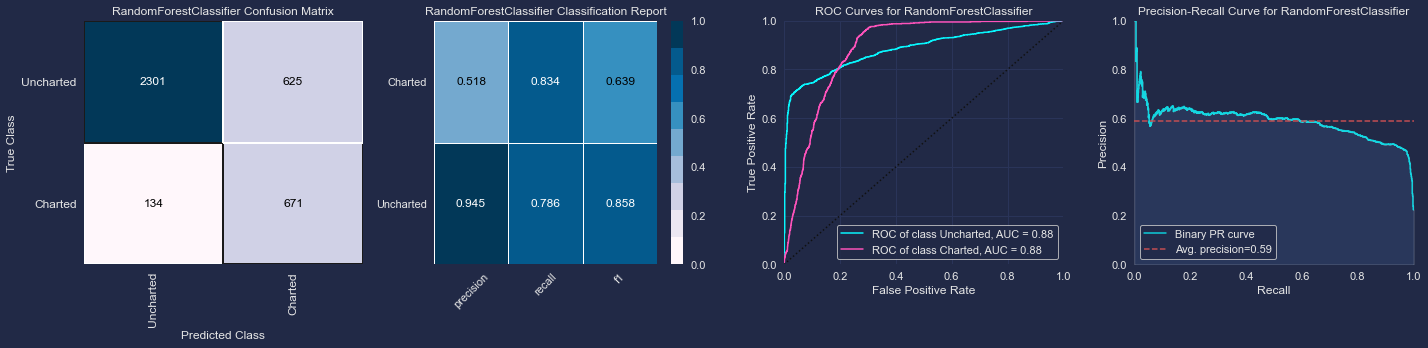

In [15]:
# Plot artist feature model
X_train_ = X_train[audio_features + artist_features]
X_test_ = X_test[audio_features + artist_features]

model = RandomForestClassifier(
    min_samples_split=5,
    min_impurity_decrease=0.0001,
    max_leaf_nodes=125,
    max_depth=40
)

pipeline = ImbalancedPipeline([
    ("smote", SMOTE(random_state=13)),
    ("scaler", StandardScaler()),
    ("classifier", model),
])

pipeline.fit(X_train_, y_train)
plot_classification_reports(pipeline, X_train_, X_test_, y_train, y_test)

### Benchmark: model trained on audio features

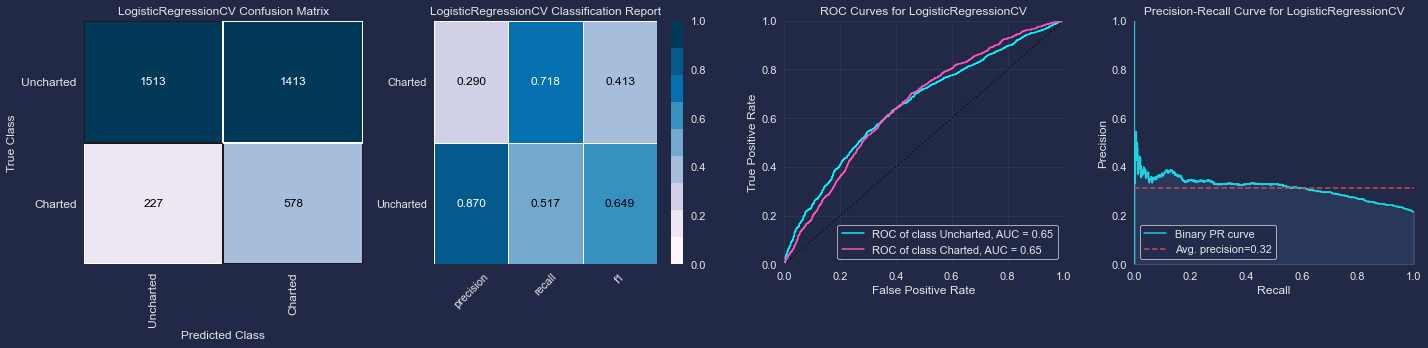

In [71]:
X_train_ = X_train[audio_features]
X_test_ = X_test[audio_features]

model = LogisticRegressionCV(
    penalty="l1",
    cv=stratified_kfold,
    max_iter=100,
    class_weight="balanced",
    scoring=make_scorer(precision_score),
    solver="liblinear"
)

pipeline = ImbalancedPipeline([
    ("smote", SMOTE(random_state=42)),
    ("scaler", StandardScaler()),
    ("classifier", model),
])

pipeline.fit(X_train_, y_train)
plot_classification_reports(pipeline, X_train_, X_test_, y_train, y_test)

Is this model under fit or overfit?

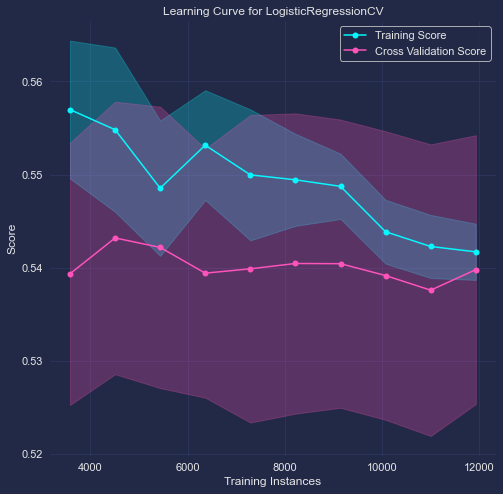

<AxesSubplot:title={'center':'Learning Curve for LogisticRegressionCV'}, xlabel='Training Instances', ylabel='Score'>

In [72]:
X = tracks_df[audio_features + artist_features]
y = tracks_df["track_chart_months"] >= 1

visualizer = LearningCurve(
    model,
    cv=StratifiedKFold(n_splits=12),
    scoring="precision",
    train_sizes=np.linspace(0.3, 1.0, 10),
    n_jobs=-1
)

visualizer.fit(X, y)
visualizer.show()

This model could use more data. It is underfitting.

### Experiment: audio features + genres

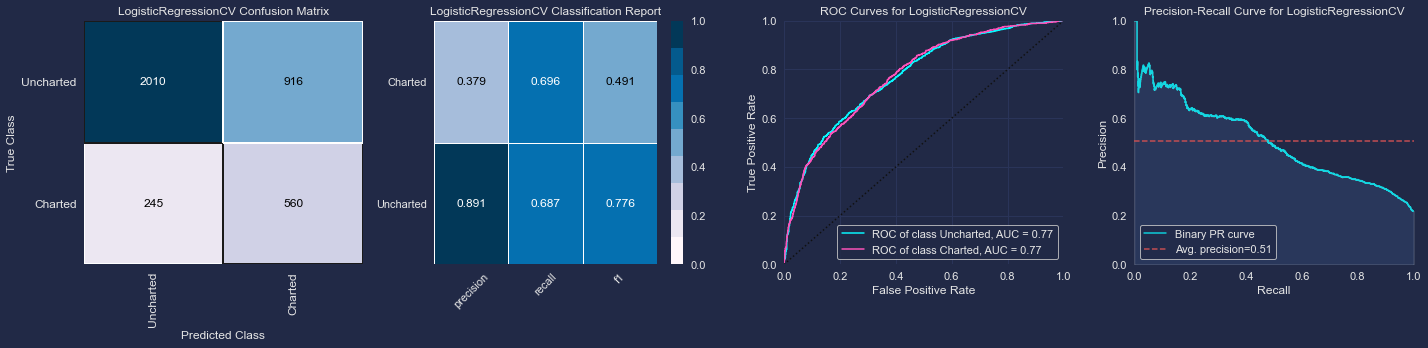

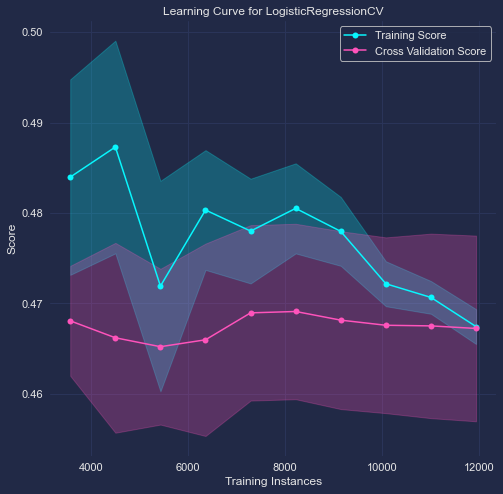

<AxesSubplot:title={'center':'Learning Curve for LogisticRegressionCV'}, xlabel='Training Instances', ylabel='Score'>

In [73]:
X_train_ = X_train[audio_features + genre_features]
X_test_ = X_test[audio_features + genre_features]

model = LogisticRegressionCV(
    penalty="l1",
    cv=stratified_kfold,
    max_iter=100,
    class_weight="balanced",
    scoring=make_scorer(precision_score),
    solver="liblinear"
)

pipeline = ImbalancedPipeline([
    ("smote", SMOTE(random_state=42)),
    ("scaler", StandardScaler()),
    ("classifier", model),
])
pipeline.fit(X_train_, y_train)

plot_classification_reports(pipeline, X_train_, X_test_, y_train, y_test)
visualizer = LearningCurve(
    model,
    cv=StratifiedKFold(n_splits=12),
    scoring="precision",
    train_sizes=np.linspace(0.3, 1.0, 10),
    n_jobs=-1
)
visualizer.fit(tracks_df[audio_features + genre_features], y)
visualizer.show()

Fits better with genre data. Training score converges to CV score. However, genres are not mutually exclusive; genres overlap. May not be reasonable to train a model on non-mutually exclusive variables, may introduce a bias to predict a class as charting or not charting based on genre, e.g., classifying pop genre songs to be more likely to chart than other songs; or trap songs, which have so far charted less often. Genre popularity have trends, and that trend is not being captured in this model. It would be better to generalize on patterns found within track's audio features that transcend the definition and contemporary popularity of genres.

In [8]:
artist_releases_features = ["artist_releases_recently"]
audio_backward_selected_features = ["acousticness", "danceability", "energy", "loudness"]
audio_selected_features_1_month = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
distance_features = ["mean_distance_uncharted", "mean_distance_charted", "mean_distance_charted_delta"]
# genre_features = genre_features.tolist()

featuresets = [
    # ("All", audio_features + artist_features + distance_features + genre_features),
    # ("Artist", artist_features),
    # ("Artist+Audio", audio_features + artist_features),
    ("Audio", audio_features),
    ("Audio+ArtistReleases", audio_features + artist_releases_features),
    ("Audio-BS", audio_backward_selected_features),
    ("Audio-BS+ArtistReleases", audio_backward_selected_features + artist_releases_features),
    ("Audio-RFE", audio_selected_features_1_month),
    ("Audio-RFE+ArtistReleases", audio_selected_features_1_month + artist_releases_features),
    ("Audio-RFE+Distances", audio_selected_features_1_month + distance_features),
    ("Audio-RFE+ArtistReleases+Distances", audio_selected_features_1_month + artist_releases_features + distance_features),
    ("Distances", distance_features),
    ("ArtistReleases+Distances", artist_releases_features + distance_features),
]

stratified_kfold = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

models = [
    ("LR-L1", LogisticRegressionCV(
        penalty="l1",
        cv=stratified_kfold,
        max_iter=100,
        class_weight="balanced",
        scoring=make_scorer(precision_score),
        solver="liblinear"
    )),
    ("LR-L2", LogisticRegressionCV(
        penalty="l2",
        cv=stratified_kfold,
        max_iter=100,
        class_weight="balanced",
        scoring=make_scorer(precision_score),
        solver="lbfgs"
    )),
    ("RF", RandomForestClassifier(
        max_depth=30,
        max_leaf_nodes=50,
        min_impurity_decrease=0.001,
        min_samples_split=5,
        random_state=23,
        class_weight="balanced",
    )),
    ("RF-Tuned", RandomForestClassifier(
        min_samples_split=5,
        min_impurity_decrease=0.0001,
        max_leaf_nodes=125,
        max_depth=40
    )),
    ("SVM-Poly", SVC(
        kernel="poly",
        gamma="auto",
        degree=2,
        probability=True,
        random_state=23,
        class_weight="balanced",
    )),
    ("SVM-RBF", SVC(
        gamma="auto",
        probability=True,
        random_state=23,
        class_weight="balanced",
    )),
    # ("DT", DecisionTreeClassifier(
    #      random_state=23,
    #      class_weight="balanced",
    # )),
    ("MLP", MLPClassifier(
        hidden_layer_sizes=(10,),
        activation="logistic",
        solver="lbfgs",
        random_state=23,
        max_iter=500
    )),
    ("MLP-Tuned", MLPClassifier(
        hidden_layer_sizes=(10, 20),
        learning_rate="constant",
        activation="tanh",
        solver="lbfgs",
        random_state=1,
        max_iter=500
    )),

]

us_tracks_df = tracks_df[(tracks_df["artist_country"] == "US")]

datasets = [
    ("Global", tracks_df),
    ("US", us_tracks_df),
]

month_mins = [1, 6]

train_validation_datasets = {}
model_scores = []

with tqdm(total=len(datasets) * len(models) * len(featuresets) * len(models)) as pbar:
    for (dataset_name, dataset), months in itertools.product(datasets, month_mins):
        dataset_key = f"{dataset_name}-{months}"

        # create train-test split with final holdout set for hyperparameter tuning.
        X_train, X_validate_threshold, y_train, y_validate_threshold = train_test_split(
            dataset, dataset["track_chart_months"] >= months,
            stratify=dataset["track_chart_months"] >= months,
            test_size=0.2, random_state=42)
        X_train, X_validate_search, y_train, y_validate_search = train_test_split(
            X_train, y_train, stratify=y_train, test_size=0.25, random_state=1)
        X_train, X_validate_model, y_train, y_validate_model = train_test_split(
            X_train, y_train, stratify=y_train, test_size=0.25, random_state=1)

        train_validation_datasets[dataset_key] = {
            "X_train": X_train,
            "y_train": y_train,
            "X_validate_model": X_validate_model,
            "y_validate_model": y_validate_model,
            "X_validate_search": X_validate_search,
            "y_validate_search": y_validate_search,
            "X_valid_on_threshold": X_validate_threshold,
            "y_valid_on_threshold": y_validate_threshold,
        }

        for (featureset_name, featureset), (model_name, model) in itertools.product(featuresets, models):
            pbar.set_description(f"Processing: dataset={dataset_key}, feature_set={featureset_name}, model={model_name}")

            # limit training and testing sets to selected features
            X_train_on_featureset = X_train[featureset]
            X_valid_on_featureset = X_validate_model[featureset]

            # How to use SMOTE:
            # https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7
            pipeline = ImbalancedPipeline([
                ("smote", SMOTE(random_state=42)),
                ("scaler", StandardScaler()),
                ("classifier", model),
            ])
            try:
                pipeline.fit(X_train_on_featureset, y_train)
                pbar.update(1)
            except ValueError as err:
                print(f"Could not fit: {err}")
                continue
            except Exception as err:
                print(f"Unknown error: {err}")
                continue

            # save model scores for later reference
            model_score = {
                "name": f"{dataset_name}-{model_name}-{featureset_name}",
                "dataset": dataset_key,
                "features": featureset_name,
                "model": model_name,
                "months": months,
            }
            model_score_ = score_model(pipeline, X_valid_on_featureset, y_validate_model)
            model_score.update(model_score_)
            model_scores.append(model_score)
            # print(model_score_)
            # don't plot hundreds of models. slows down the loop and eats up memory
            # plot_classification_reports(pipeline, X_train, X_test, y_train, y_test)

Processing: dataset=US-6, feature_set=ArtistReleases+Distances, model=SVM-RBF:  33%|███▎      | 120/360 [10:44<21:29,  5.37s/it]               


In [30]:
model_scores_df = pd.DataFrame(model_scores)
model_scores_df.sort_values("precision", ascending=False).drop(columns="name").head(20)

,dataset,features,model,months,precision,recall,accuracy,f1,auc
68,US-1,Audio-RFE+ArtistReleases,RF,1,0.490617,0.584665,0.633028,0.533528,0.622386
69,US-1,Audio-RFE+ArtistReleases,RF-Tuned,1,0.487671,0.568690,0.630734,0.525074,0.617082
80,US-1,Audio-RFE+ArtistReleases+Distances,RF,1,0.483627,0.613419,0.626147,0.540845,0.623346
79,US-1,Audio-RFE+ArtistReleases+Distances,LR-L2,1,0.479730,0.680511,0.620413,0.562748,0.633637
67,US-1,Audio-RFE+ArtistReleases,LR-L2,1,0.476923,0.693291,0.616972,0.565104,0.633765
81,US-1,Audio-RFE+ArtistReleases+Distances,RF-Tuned,1,0.475936,0.568690,0.620413,0.518195,0.609032
63,US-1,Audio-RFE,RF-Tuned,1,0.474747,0.600639,0.618119,0.530324,0.614273
78,US-1,Audio-RFE+ArtistReleases+Distances,LR-L1,1,0.473913,0.696486,0.613532,0.564036,0.631785
75,US-1,Audio-RFE+Distances,RF-Tuned,1,0.473301,0.623003,0.615826,0.537931,0.617405
62,US-1,Audio-RFE,RF,1,0.473094,0.674121,0.613532,0.555995,0.626864


### Compare all the models

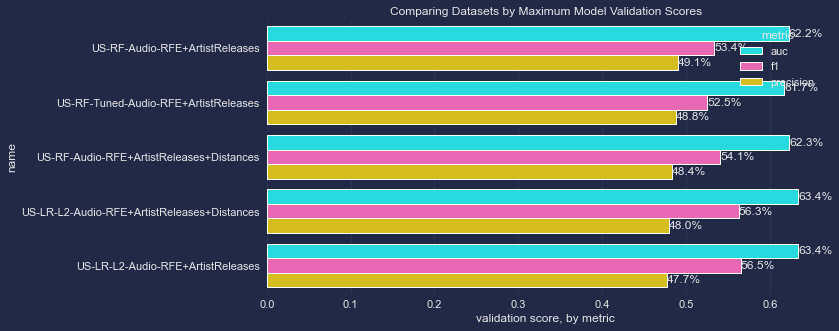

In [23]:
fig, ax1 = plt.subplots(figsize=(10, 5))
tidy = model_scores_df.sort_values("precision", ascending=False).head(5).melt(id_vars="name", value_vars=["auc", "f1", "precision"])
tidy["metric"] = tidy["variable"]
tidy["validation score, by metric"] = tidy["value"]
ax = sns.barplot(y="name", x='validation score, by metric', hue='metric', data=tidy, ax=ax1)
sns.despine(fig)
for container in ax.containers:
    ax.bar_label(container, labels=[f"{score*100:.1f}%" for score in container.datavalues])
ax.set_title("Comparing Datasets by Maximum Model Validation Scores");

### Compare best models by dataset

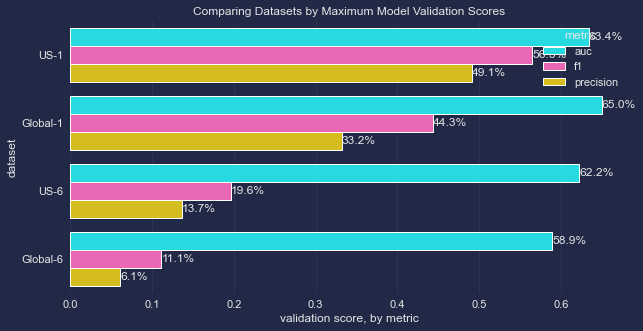

In [25]:
grouped_model_scores_df = (
    model_scores_df
        .groupby("dataset")
        .aggregate({
            "precision": "max",
            "auc": "max",
            "f1": "max",
        })
        .reset_index()
)
fig, ax1 = plt.subplots(figsize=(10, 5))
tidy = grouped_model_scores_df.sort_values("precision", ascending=False).head(5).melt(id_vars="dataset", value_vars=["auc", "f1", "precision"])
tidy["metric"] = tidy["variable"]
tidy["validation score, by metric"] = tidy["value"]
ax = sns.barplot(y="dataset", x='validation score, by metric', hue='metric', data=tidy, ax=ax1)
sns.despine(fig)
for container in ax.containers:
    ax.bar_label(container, labels=[f"{score*100:.1f}%" for score in container.datavalues])
ax.set_title("Comparing Datasets by Maximum Model Validation Scores");

### Compare best models by feature set

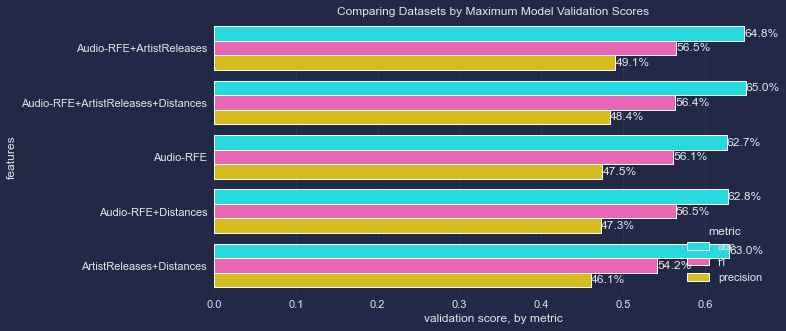

In [26]:
grouped_model_scores_df = (
    model_scores_df
        .groupby("features")
        .aggregate({
            "precision": "max",
            "auc": "max",
            "f1": "max",
        })
        .reset_index()
)
fig, ax1 = plt.subplots(figsize=(10, 5))
tidy = grouped_model_scores_df.sort_values("precision", ascending=False).head(5).melt(id_vars="features", value_vars=["auc", "f1", "precision"])
tidy["metric"] = tidy["variable"]
tidy["validation score, by metric"] = tidy["value"]
ax = sns.barplot(y="features", x='validation score, by metric', hue='metric', data=tidy, ax=ax1)
sns.despine(fig)
for container in ax.containers:
    ax.bar_label(container, labels=[f"{score*100:.1f}%" for score in container.datavalues])
ax.set_title("Comparing Datasets by Maximum Model Validation Scores");

### Compare best models by model family

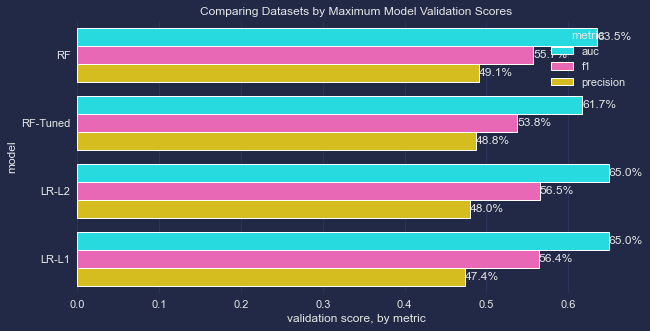

In [27]:
grouped_model_scores_df = (
    model_scores_df
        .groupby("model")
        .aggregate({
            "precision": "max",
            "auc": "max",
            "f1": "max",
        })
        .reset_index()
)
fig, ax1 = plt.subplots(figsize=(10, 5))
tidy = grouped_model_scores_df.sort_values("precision", ascending=False).head(4).melt(id_vars="model", value_vars=["auc", "f1", "precision"])
tidy["metric"] = tidy["variable"]
tidy["validation score, by metric"] = tidy["value"]
ax = sns.barplot(y="model", x='validation score, by metric', hue='metric', data=tidy, ax=ax1)
sns.despine(fig)
for container in ax.containers:
    ax.bar_label(container, labels=[f"{score*100:.1f}%" for score in container.datavalues])
ax.set_title("Comparing Datasets by Maximum Model Validation Scores");

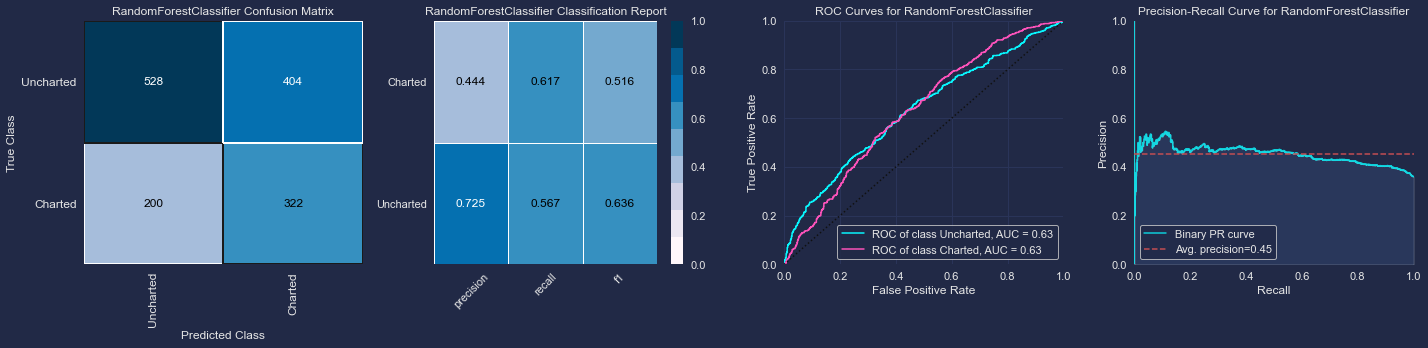

In [90]:
# Otherwise, best other model:

model = RandomForestClassifier(
    min_samples_split=5,
    min_impurity_decrease=0.0001,
    max_leaf_nodes=125,
    max_depth=40
)

pipeline = ImbalancedPipeline([
    ("smote", SMOTE(random_state=42)),
    ("scaler", StandardScaler()),
    ("classifier", model),
])
X_train, X_test, y_train, y_test = create_test_train_datasets(us_tracks_df, audio_selected_features_1_month + artist_releases_features, months=1, test_size=0.25)
pipeline.fit(X_train, y_train)
plot_classification_reports(pipeline, X_train, X_test, y_train, y_test)

## Fine-tune hyper-parameters

In [33]:
train_validation_datasets["US-1"]["X_train"]

dict_keys(['X_train', 'y_train', 'X_validate_model', 'y_validate_model', 'X_validate_search', 'y_validate_search', 'X_valid_on_threshold', 'y_valid_on_threshold'])

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

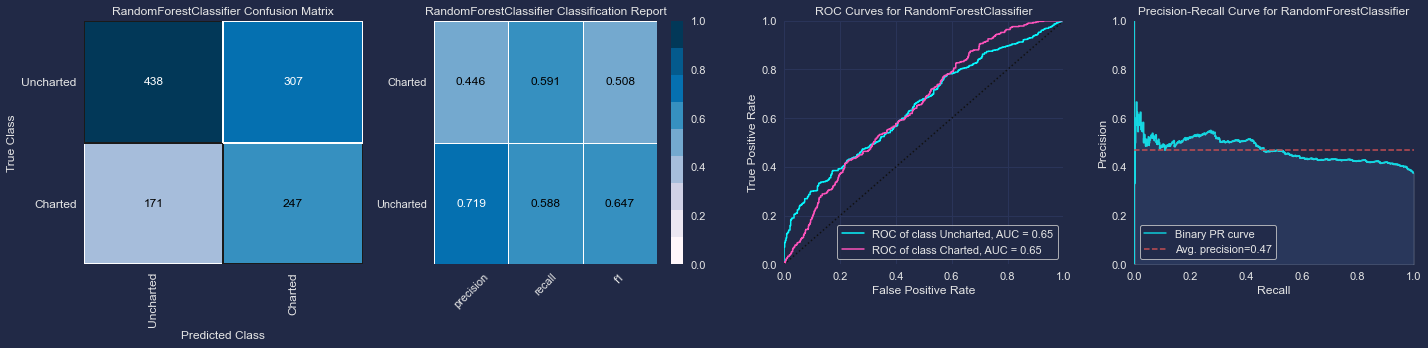

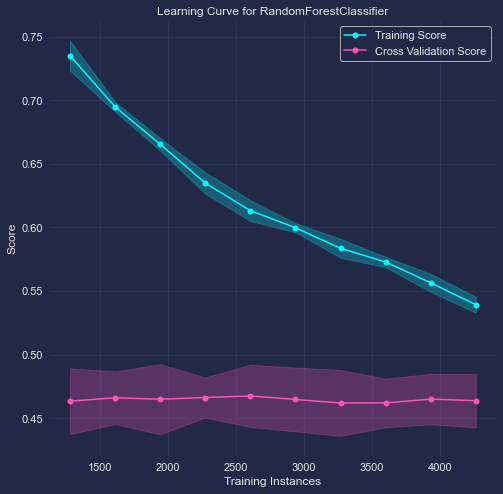

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [65]:
from scipy import stats

dataset_key = "US-1"
features = audio_selected_features_1_month + artist_releases_features

X_train = pd.concat([
    train_validation_datasets[dataset_key]["X_train"][features],
    train_validation_datasets[dataset_key]["X_validate_model"][features]
])
y_train = pd.concat([
    train_validation_datasets[dataset_key]["y_train"],
    train_validation_datasets[dataset_key]["y_validate_model"]
])
X_test = train_validation_datasets[dataset_key]["X_validate_search"][features]
y_test = train_validation_datasets[dataset_key]["y_validate_search"]

stratified_kfold = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=44,
)

n_iter = 100

model = RandomForestClassifier(
    max_depth=30,
    max_leaf_nodes=50,
    min_impurity_decrease=0.001,
    min_samples_split=5,
    random_state=23,
    class_weight="balanced",
)

param_grid = {
    "classifier__n_estimators": np.arange(5, 500, 100),
    "classifier__min_samples_split": stats.uniform(0, 1),
    "classifier__max_leaf_nodes": np.arange(25, 150, 100),
    "classifier__min_impurity_decrease": stats.uniform(0, .0001),
    "classifier__max_depth": np.arange(2, 500, 100),
}

pipeline = ImbalancedPipeline([
    ("smote", SMOTE(random_state=42)),
    ("scaler", StandardScaler()),
    ("classifier", model),
])

gs = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    scoring={
        "precision": make_scorer(precision_score),
        "recall": make_scorer(recall_score),
        "accuracy": make_scorer(accuracy_score),
        "f1": make_scorer(f1_score),
        "rocauc": make_scorer(roc_auc_score),
    },
    refit="precision",
    cv=stratified_kfold,
    n_jobs=-1,
    n_iter=n_iter,
)
gs.fit(X_train, y_train)

plot_classification_reports(pipeline, X_train, X_test, y_train, y_test)

visualizer = LearningCurve(
    pipeline,
    cv=StratifiedKFold(n_splits=12),
    scoring="precision",
    train_sizes=np.linspace(0.3, 1.0, 10),
    n_jobs=-1
)
visualizer.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))
visualizer.show()

In [47]:
gs.best_params_

{'classifier__max_depth': 102,
 'classifier__max_leaf_nodes': 125,
 'classifier__min_impurity_decrease': 7.704396929163026e-05,
 'classifier__min_samples_split': 0.056375913187962756,
 'classifier__n_estimators': 305}

Learning curve shows this model is over-fitting and needs more data.

### Fine-tune threshold
Tuning threshold and testing against yet another validation set

In [77]:
dataset_key = "US-1"
features = audio_selected_features_1_month + artist_releases_features

n_iter = 50

X_train = pd.concat([
    train_validation_datasets[dataset_key]["X_train"][features],
    train_validation_datasets[dataset_key]["X_validate_model"][features],
    train_validation_datasets[dataset_key]["X_validate_search"][features]
])
y_train = pd.concat([
    train_validation_datasets[dataset_key]["y_train"],
    train_validation_datasets[dataset_key]["y_validate_model"],
    train_validation_datasets[dataset_key]["y_validate_search"]
])
X_test = train_validation_datasets[dataset_key]["X_valid_on_threshold"][features]
y_test = train_validation_datasets[dataset_key]["y_valid_on_threshold"]

model = Thresholder(
    RandomForestClassifier(**{
            'max_depth': 102,
            'max_leaf_nodes': 125,
            'min_impurity_decrease': 7.704396929163026e-05,
            'min_samples_split': 0.056375913187962756,
            'n_estimators': 305
        }
    ),
    threshold=0.50
)

pipeline = ImbalancedPipeline([
    ("smote", SMOTE(random_state=42)),
    ("scaler", StandardScaler()),
    ("classifier", model),
])

gs = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions={"classifier__threshold": np.linspace(0.1, 0.9, 50)},
    scoring={
        "precision": make_scorer(precision_score),
        "recall": make_scorer(recall_score),
        "accuracy": make_scorer(accuracy_score),
        "f1": make_scorer(f1_score),
        "rocauc": make_scorer(roc_auc_score),
    },
    refit="precision",
    cv=stratified_kfold,
    n_jobs=-1,
    n_iter=n_iter,
)
gs.fit(X_train, y_train)

cv_results_df = (
    pd.DataFrame(gs.cv_results_)
        .sort_values("param_classifier__threshold")
        .set_index("param_classifier__threshold")
        .rename(columns={
            "mean_test_precision": "precision",
            "mean_test_recall": "recall",
            "mean_test_accuracy": "accuracy",
            "mean_test_f1": "f1",
            "mean_test_rocauc": "rocauc",
    })[[
        "precision",
        "recall",
        "accuracy",
        "f1",
        "rocauc",
    ]]
)

best_precision = np.max(cv_results_df["precision"])
best_precision_threshold = cv_results_df.index[np.argmax(cv_results_df["precision"])]
print(f"best precision: precision={best_precision} @ threshold={best_precision_threshold}")

/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pez/.conda/envs/dataspell-2/lib/python3.9/site-pack

best precision: precision=0.7257657901870426 @ threshold=0.7367346938775511


<AxesSubplot:xlabel='param_classifier__threshold'>

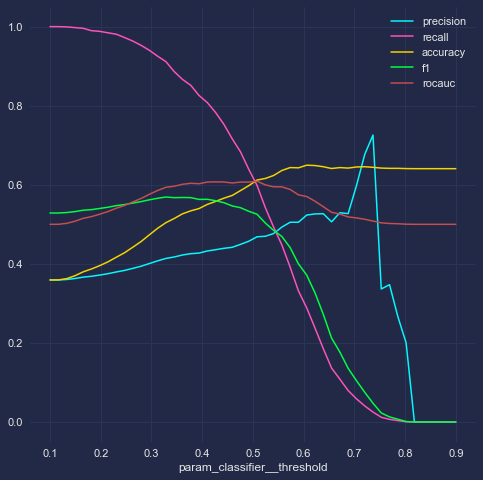

In [79]:
cv_results_df.plot()

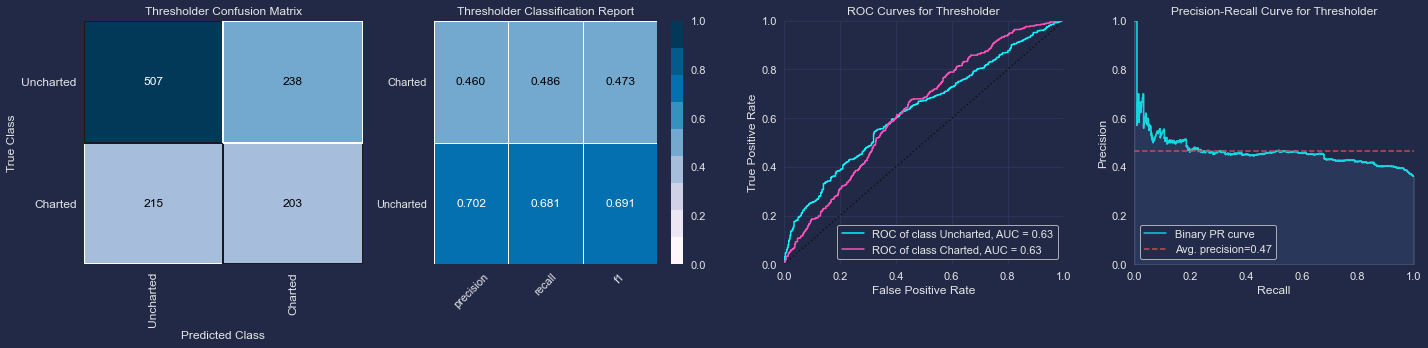

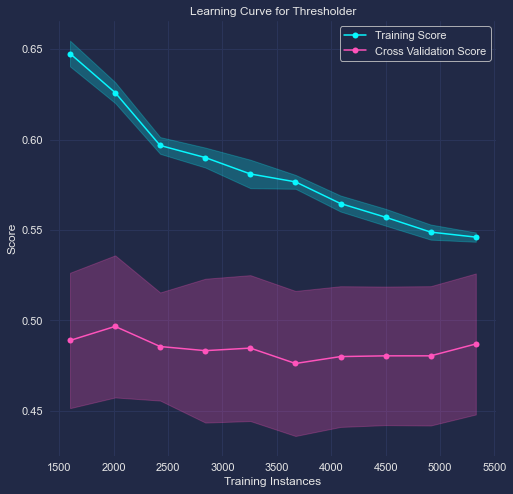

<AxesSubplot:title={'center':'Learning Curve for Thresholder'}, xlabel='Training Instances', ylabel='Score'>

In [115]:
model = Thresholder(
    RandomForestClassifier(**{
        'max_depth': 102,
        'max_leaf_nodes': 125,
        'min_impurity_decrease': 7.704396929163026e-05,
        'min_samples_split': 0.056375913187962756,
        'n_estimators': 305
    }),
    threshold=0.55  # better to look at the graphic than to try to automate this
)

pipeline = ImbalancedPipeline([
    ("smote", SMOTE(random_state=42)),
    ("scaler", StandardScaler()),
    ("classifier", model),
])
plot_classification_reports(pipeline, X_train, X_test, y_train, y_test)

visualizer = LearningCurve(
    pipeline,
    cv=StratifiedKFold(n_splits=12),
    scoring="precision",
    train_sizes=np.linspace(0.3, 1.0, 10),
    n_jobs=-1
)
visualizer.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))
visualizer.show()

Still overfitting.

How's it do on songs from 2017-2019?

In [116]:
tracks_new_artists_df = tracks_df[
    (tracks_df["year"].isin([2017, 2018, 2019]))
    & (tracks_df["artist_chart_months"] == 0)
    & (tracks_df["artist_country"] == "US")
    # & (tracks_df["artist_lifetime_chart_months"] >= 1)
    # & (tracks_df["track_chart_months"] >= 1)
    ][["artists", "name", "track_chart_months", "artist_chart_months", "artist_lifetime_chart_months"]]
tracks_new_artists_df = pd.merge(X_test, tracks_new_artists_df, left_on=X_test.index, right_on=tracks_new_artists_df.index, how="left").dropna()

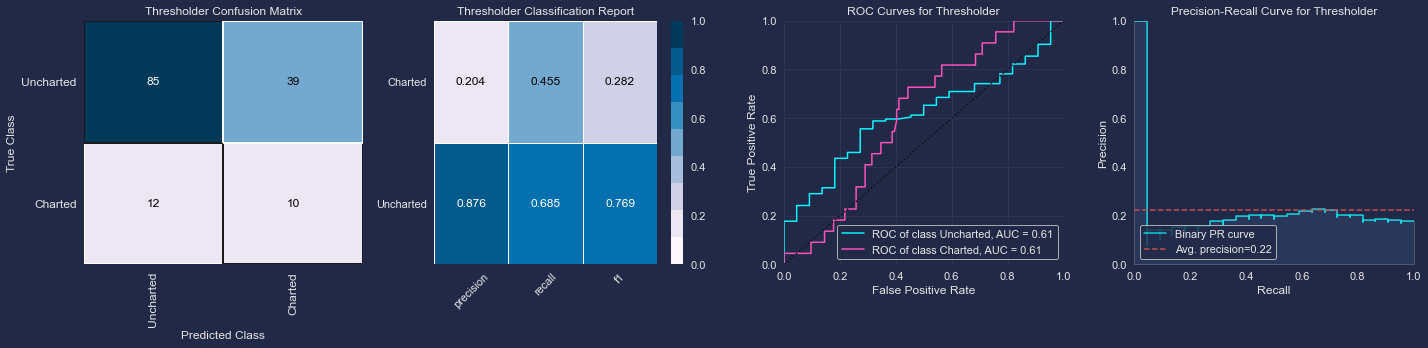

In [117]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
visualgrid = [
    ConfusionMatrix(pipeline, ax=axes[0], cmap="PuBu", classes=[0, 1], encoder={0: "Uncharted", 1: "Charted"}),
    ClassificationReport(pipeline, ax=axes[1], cmap="PuBu", support=False, classes=[0, 1], encoder={0: "Uncharted", 1: "Charted"}),
    ROCAUC(pipeline, ax=axes[2], macro=False, micro=False, per_class=True, classes=[0, 1], encoder={0: "Uncharted", 1: "Charted"}),
    PrecisionRecallCurve(pipeline, micro=False, ax=axes[3], classes=[0, 1], encoder={0: "Uncharted", 1: "Charted"}),
]
for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(tracks_new_artists_df[X_test.columns], tracks_new_artists_df["track_chart_months"] >= 1)
    viz.finalize()
plt.show()

Not great.

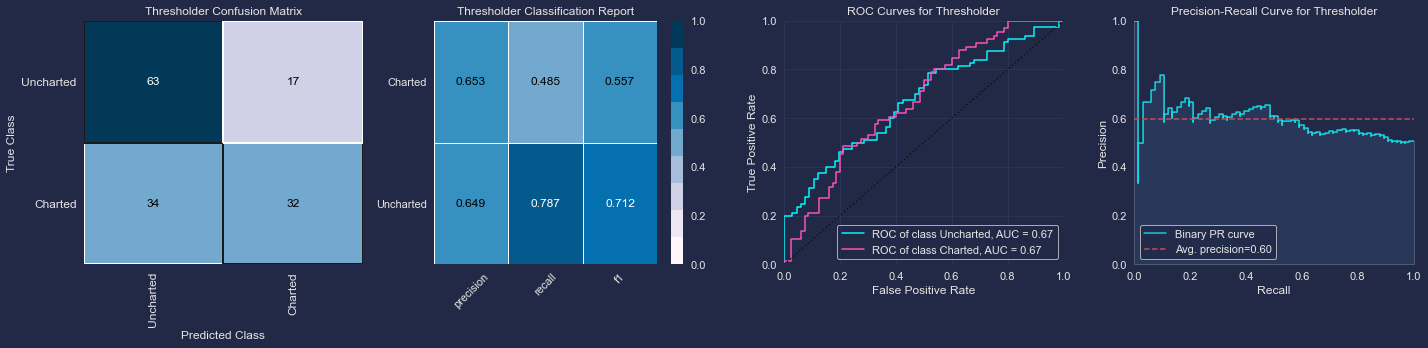

In [118]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
visualgrid = [
    ConfusionMatrix(pipeline, ax=axes[0], cmap="PuBu", classes=[0, 1], encoder={0: "Uncharted", 1: "Charted"}),
    ClassificationReport(pipeline, ax=axes[1], cmap="PuBu", support=False, classes=[0, 1], encoder={0: "Uncharted", 1: "Charted"}),
    ROCAUC(pipeline, ax=axes[2], macro=False, micro=False, per_class=True, classes=[0, 1], encoder={0: "Uncharted", 1: "Charted"}),
    PrecisionRecallCurve(pipeline, micro=False, ax=axes[3], classes=[0, 1], encoder={0: "Uncharted", 1: "Charted"}),
]
for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(tracks_new_artists_df[X_test.columns], tracks_new_artists_df["artist_lifetime_chart_months"] >= 1)
    viz.finalize()
plt.show()

However, if we look at artist's lifetime achievement, this model does decent predicting that. Tracks that were predicted to have chart, the artists saw commercial success later in their careers.

In [122]:
tracks_new_artists_df["y_pred"] = tracks_new_artists_df["artist_lifetime_chart_months"] >= 1
tracks_new_artists_df[tracks_new_artists_df["y_pred"] == 1][["artists", "name", "track_chart_months", "artist_chart_months", "artist_lifetime_chart_months"]].head(50)

,artists,name,track_chart_months,artist_chart_months,artist_lifetime_chart_months
54,Juice WRLD,Black & White,0.0,0.0,14.0
57,"SAINt JHN, Imanbek",Roses - Imanbek Remix,0.0,0.0,11.0
83,"French Montana, Swae Lee",Unforgettable,0.0,0.0,9.0
116,Lil Mosey,Noticed,0.0,0.0,7.0
127,Lil Uzi Vert,XO Tour Llif3,7.0,0.0,11.0
135,Lauv,Enemies,0.0,0.0,1.0
196,Portugal. The Man,Feel It Still,9.0,0.0,9.0
213,Trevor Daniel,Falling,0.0,0.0,8.0
215,"Maren Morris, Brandi Carlile",Common (feat. Brandi Carlile),0.0,0.0,10.0
217,Kodak Black,Tunnel Vision,2.0,0.0,7.0
